**WARNING ! THE MEMBRANE SHOULD BE ALIGNED ON THE Z AXIS FIRST ! NO MEMBRANE ROTATION!!!**

In [1]:
WORKDIR = "/Users/thibault/Documents/WORK/simu/mahmoud/ForThibault"
TRAJ = f"{WORKDIR}/traj.xtc"
TOPOL = f"{WORKDIR}/topol.pdb"

membraneLayerResidue = "residue 129 to 256"
proteinSelection="protein"


TODO :

Find automatic upper and lower:
1. calculate the average Z of all P
2. Get Z of every lipid
3. Z > average Z means upper leaflet....

In [2]:
import mdtraj as md
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nglview as nv
import pandas as pd

In [3]:
traj = md.load(TRAJ, top=TOPOL)

In [5]:
def calc_depth(traj, membraneLayerResidue, proteinSelection="protein"):

    #1. Averaging all P Z coordinate, along the trajectory
    Pplan = traj.top.select(f"({membraneLayerResidue}) and symbol P") # Get all the phosphate of the selected lipids
    average_phosphate = np.mean(traj.atom_slice(Pplan).xyz,axis=1) #calculate the average of all coordinates
    average_Z_phosphate = np.array([x[2] for x in average_phosphate]) #Average on Z only for every frames

    #2. Averagine the protein now.
    protSelection = traj.atom_slice(traj.top.select(f"{proteinSelection} and name CA")) #Get only the protein (AND CA)
    index = [x.residue.resSeq for x in protSelection.top.atoms] #Get the Residue number
    average_protCA = np.mean(protSelection.xyz,axis=1) #Average of all CA atoms in every frames
    std_prot_CA = np.std(protSelection.xyz,axis=1)
    average_Z_CA = np.array([x[2] for x in  average_protCA]) #Average of Z only atoms in every frames
    std_Z_prot_CA = np.std(protSelection.xyz,axis=1)

    allz = protSelection.xyz[:,:,2]

    #nframe = protSelection.n_frames
    depth_res_time = []
    for i in range(allz.shape[1]):
        depth = average_Z_phosphate - allz[:,i]
        depth_res_time.append(depth)
    depth_res_time = np.asarray(depth_res_time)

    depth_res_time
    df = pd.DataFrame(depth_res_time, index=index)
    df = df*10

    return (df)

    


In [6]:
all_dataframe = calc_depth(traj, membraneLayerResidue, proteinSelection)
all_dataframe

,0,1,2,3,4,5,6,7,8,9,...,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243
362,49.103245,49.556065,48.932655,40.370174,30.534443,28.124445,30.772915,34.512566,37.087093,28.462744,...,31.355400,32.205223,29.520008,27.704369,28.195133,26.152399,34.543427,35.934528,25.330345,26.857367
363,46.603245,49.146061,46.212654,42.000175,31.174446,28.914444,33.272915,32.572563,33.737091,26.742744,...,34.445400,34.035225,32.970009,31.384369,31.485134,30.012398,34.323425,35.454529,28.830345,30.237370
364,46.363243,47.596062,45.832653,42.000175,34.524445,31.484444,35.282913,31.602566,32.097092,27.542744,...,36.245399,33.815224,33.990009,33.454365,34.995136,33.252399,32.193428,34.164528,30.050344,31.057367
365,42.513241,44.236061,42.072655,38.540176,34.524445,32.584442,36.462914,33.282562,34.617096,30.692745,...,35.415401,35.495224,35.280006,34.754368,35.755135,34.242397,33.753426,34.844528,31.180344,32.747368
366,40.363243,41.146057,39.722652,36.250175,37.774445,35.294445,35.372917,34.352566,34.177094,31.122742,...,32.115398,33.135223,32.530006,31.834366,33.015133,30.882399,31.043427,31.894527,28.250347,29.837368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,42.613243,41.546059,39.322655,34.740177,34.954449,31.434443,25.732914,27.462566,24.217094,28.112745,...,39.735401,34.345222,36.240009,39.724365,36.495136,35.542397,35.833427,30.304527,31.720345,32.647366
595,45.993240,45.036057,42.762657,38.530178,38.804443,35.304443,29.502911,31.122562,28.027096,31.502743,...,43.125401,38.135223,39.920010,43.084370,40.135136,39.342400,39.593426,34.044529,35.390343,36.497368
596,46.163246,45.706062,43.672657,40.190178,40.434448,37.344444,32.302914,33.822563,30.277096,34.232746,...,43.525398,39.285225,40.270008,42.674366,40.645138,40.412399,40.473427,35.764526,36.060345,37.517365
597,46.273247,48.366058,45.152657,41.640175,41.944447,39.194443,34.662914,35.842564,32.917095,35.662743,...,45.085403,41.265224,41.870007,44.404369,41.955139,41.832397,41.453430,39.424530,38.110344,40.827370


<AxesSubplot:>

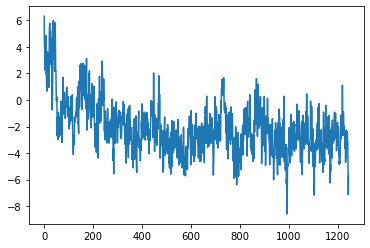

In [49]:
def get_depth_for_residue(data, residueNumber):
    return data.loc[residueNumber,]

df474 = get_depth_for_residue(all_dataframe, 474)
df474.plot()

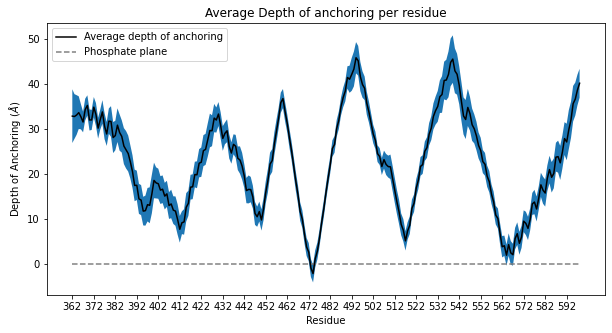

In [54]:
def average_in_time(data, title="", tick_every=10):
    dataplot = data.mean(axis=1).reset_index()
    dataplot = dataplot.rename(columns={"index":"Residue", 0:"Depth"})
    dataplot["std"] = data.std(axis=1).reset_index()[0]
    fig, ax = plt.subplots(figsize=(10,5))

    minres = dataplot.Residue.min()
    maxres = dataplot.Residue.max()
    graph = sns.lineplot(x="Residue", y="Depth", data=dataplot, color="black", ax=ax)
    graph.set(ylabel=r"Depth of Anchoring ($\AA$)", xlabel="Residue", title=title)
    hline = plt.hlines(y=0, xmin=minres, xmax = maxres, color="gray", linestyles='dashed')
    graph.fill_between(dataplot.Residue, dataplot.Depth-dataplot["std"],dataplot.Depth+dataplot["std"])
    

    graph.set_xticks(range(minres, maxres, tick_every))

    #Now the legend
    plt.legend(labels=["Average depth of anchoring","Phosphate plane"])



    
    
average_in_time(all_dataframe, title="Average Depth of anchoring per residue")

In [47]:
all_dataframe.std(axis=1).reset_index()[0]

0      5.964097
1      4.965118
2      4.402527
3      3.618567
4      2.787221
         ...   
232    4.022871
233    3.947265
234    3.662881
235    3.412341
236    3.208020
Name: 0, Length: 237, dtype: float32

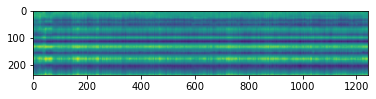

In [8]:
plt.imshow(all_dataframe.values)